In [1]:
# https://jeremy9959.net/Blog/StanMixture/

In [2]:
import numpy as np
from numpy.random import *
import pystan
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from scipy.special import expit

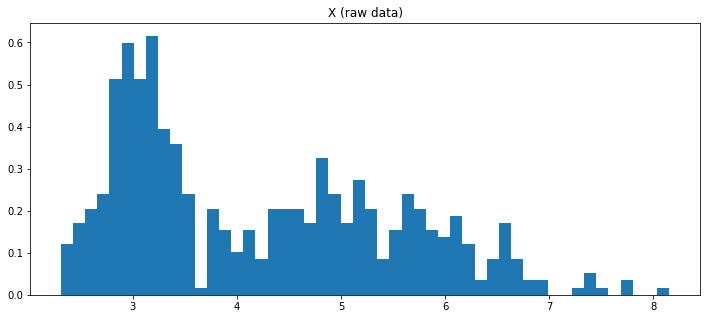

In [3]:
K = 2

A_mu = 3
B_mu = 5

A_sigma = 0.3
B_sigma = 1

A_num = 200
B_num = 300
total = A_num + B_num

A = np.random.normal(loc = A_mu, scale = A_sigma, size = A_num)
B = np.random.normal(loc = B_mu, scale = B_sigma, size = B_num)

X = np.concatenate([A, B])

plt.figure(figsize=(12, 5))
plt.title('X (raw data)')
plt.hist(X, bins = 50, density=True)
plt.show()

In [4]:
df = pd.DataFrame({
    'X': X,})

df.head(10)

,X
0,3.399084
1,2.825381
2,3.196578
3,3.177996
4,3.215630
5,2.938444
6,3.163349
7,3.026005
8,2.913546
9,2.878107


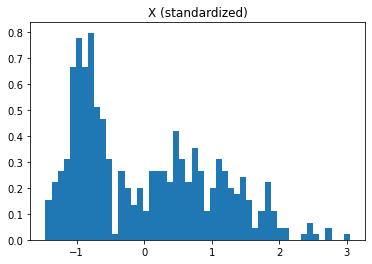

In [5]:
from sklearn.preprocessing import StandardScaler
dfs = StandardScaler().fit_transform(df)
plt.title('X (standardized)')
ax = plt.hist(dfs[:,0], bins=50, density=True)

In [6]:
stan_data={'N':dfs.shape[0],'y':dfs[:,0]}

In [7]:
# dfsは正規化されたdfであり、以下のmodelブロック事前分布は正規分布を基にした

stan_code="""
data {
    int<lower = 0> N;
    vector[N] y;
}

parameters {
    ordered[2] mu;
    real<lower=0> sigma[2];
    real<lower=0, upper=1> theta;
}

model {
    sigma ~ normal(0, 1);
    mu ~ normal(0, 1);
    theta ~ beta(5, 5);
    for (n in 1:N)
        target += log_mix(theta,
            normal_lpdf(y[n] | mu[1], sigma[1]),
            normal_lpdf(y[n] | mu[2], sigma[2]));
}
"""

In [8]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ef9cbf7b8410f13bec290c9a5b7f6ccb NOW.


In [9]:
mcmc_result = model.sampling(data=stan_data, iter=4000, warmup=1000)
print(mcmc_result)

Inference for Stan model: anon_model_ef9cbf7b8410f13bec290c9a5b7f6ccb.
4 chains, each with iter=4000; warmup=1000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      -0.9  2.0e-4   0.02  -0.94  -0.92   -0.9  -0.89  -0.86  10110    1.0
mu[2]      0.69  6.9e-4   0.07   0.56   0.65    0.7   0.74   0.82   9474    1.0
sigma[1]   0.24  1.6e-4   0.02   0.21   0.23   0.24   0.25   0.27  10131    1.0
sigma[2]   0.79  4.8e-4   0.05    0.7   0.76   0.79   0.82   0.88   9326    1.0
theta      0.44  2.9e-4   0.03   0.38   0.42   0.44   0.46   0.49   9716    1.0
lp__     -606.6    0.02   1.61 -610.5 -607.4 -606.2 -605.4 -604.4   5373    1.0

Samples were drawn using NUTS at Sat Oct  2 07:31:58 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [10]:
normal1_mu = mcmc_result['mu[1]'].mean()
normal2_mu = mcmc_result['mu[2]'].mean()
normal1_sigma = mcmc_result['sigma[1]'].mean()
normal2_sigma = mcmc_result['sigma[2]'].mean()
theta = mcmc_result['theta'].mean()

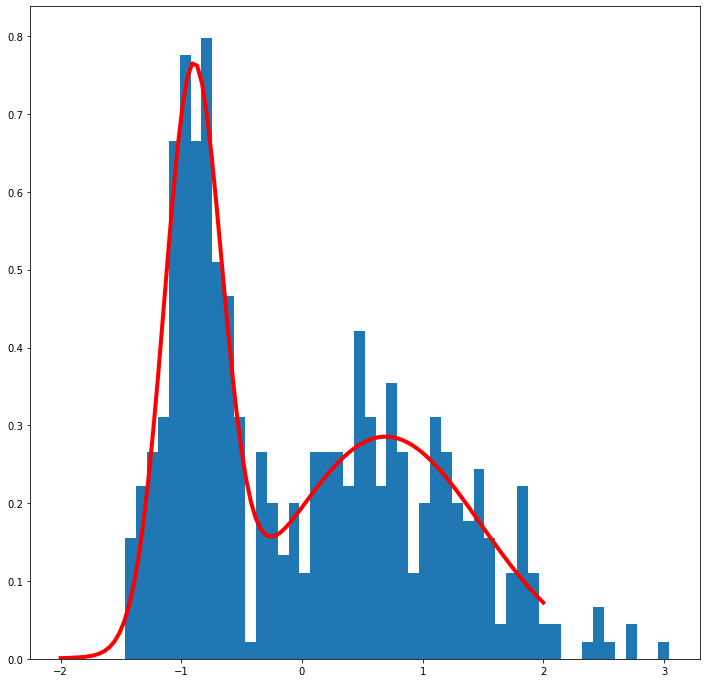

In [11]:
from scipy.stats import norm
fig, axes = plt.subplots(1, figsize = (12, 12))
axes.hist(dfs[:,0], bins=50, density=True)
x=np.linspace(-2,2,100)
ax = axes.plot(x, theta*norm.pdf(x, loc=normal1_mu,scale=normal1_sigma)+(1-theta)*norm.pdf(x,loc=normal2_mu,scale=normal2_sigma), linewidth=4, color='red')